# Call Functions in Dynamic Library

## install emsdk

* download emsdk from https://github.com/emscripten-core/emsdk
* run `emsdk install latest` to install emsdk
* run `emsdk activate latest` to activate the tools
* run `emcc -s SIDE_MODULE=1 mylib.c -o mylib.wasm`
* upload `mylib.wasm` to jupyterlite

There is a bug in pyodide-0.21.3 that cannot read file correctly. If you run pyodide locally, download the fixed file from https://ruoyu0088.github.io/pyscript_demo/pyodide/pyodide.asm.js. Or add following configure to `jupyter-lite.json`

```
"litePluginSettings": {
    "@jupyterlite/pyolite-kernel-extension:kernel": {
    "pyodideUrl": "https://ruoyu0088.github.io/pyscript_demo/pyodide/pyodide.js"
    }
}
```      

In [5]:
import numpy as np
arr = np.random.randn(100)

## Call with CFFI

In [1]:
from cffi import FFI
ffi = FFI()
ffi.cdef('''
double hypot(double, double);
double mysum(double *, int);
typedef struct _IIR2
{
    float b0, b1, b2;
    float a1, a2;
    float z0, z1;
} IIR2;

void iir2_init(IIR2 * self);
float iir2_step(IIR2 * self, float x);
void iir2_run(IIR2 * self, float * x, float * y, size_t n);
''')
lib = ffi.dlopen('mylib.wasm')
lib.hypot(3, 4)

5.0

### NumPy Array as Argument

In [19]:
lib.mysum(ffi.from_buffer('double[]', arr), len(arr)), np.sum(arr)

(-1.3871905398667335, -1.3871905398667352)

### Structure

In [21]:
%matplotlib inline
import pylab as pl

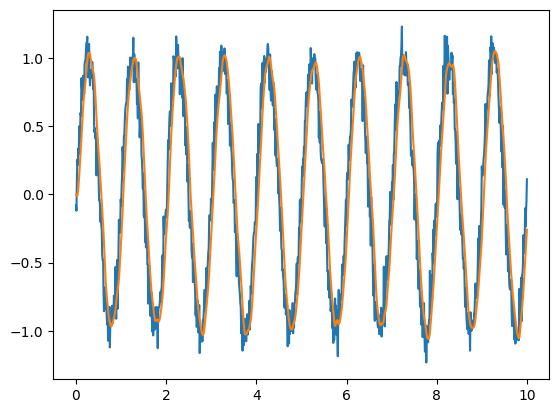

In [22]:
n = 1000
t = np.linspace(0, 10, n)
x = (np.random.randn(n) * 0.1 + np.sin(2*np.pi*t)).astype(np.float32)

b = [0.02008337, 0.04016673, 0.02008337]
a = [ 1.        , -1.56101808,  0.64135154]

iir = ffi.new("IIR2 *", dict(b0=b[0], b1=b[1], b2=b[2], a1=a[1], a2=a[2]))
lib.iir2_init(iir)
y = np.zeros_like(x)
lib.iir2_run(iir, ffi.from_buffer("float []", x), ffi.from_buffer("float []", y), len(x))
pl.plot(t, x)
pl.plot(t, y);

## Call with ctypes

In [47]:
from ctypes import cdll, c_double, c_int, Structure, c_float, POINTER, c_size_t, byref
from numpy.ctypeslib import ndpointer

In [48]:
lib2 = cdll.LoadLibrary('mylib.wasm')

In [49]:
lib2.hypot.argtypes = c_double, c_double
lib2.hypot.restype  = c_double
lib2.hypot(3, 4)

5.0

### NumPy Array as Argument

In [50]:
lib2.mysum.argtypes = ndpointer(c_double, flags="C_CONTIGUOUS"), c_int
lib2.mysum.restype = c_double
lib2.mysum(arr, len(arr))

20.61403042516793

### Structure

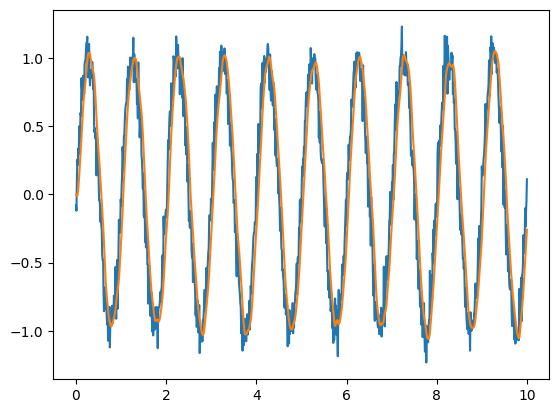

In [52]:
class IIR(Structure):
    _fields_ = [
        ("b0", c_float),
        ("b1", c_float),
        ("b2", c_float),
        ("a1", c_float),
        ("a2", c_float),
        ("z0", c_float),
        ("z1", c_float),
    ]
    
lib2.iir2_init.argtypes = POINTER(IIR),
lib2.iir2_run.argtypes = POINTER(IIR), ndpointer(c_float, flags="C_CONTIGUOUS"), ndpointer(c_float, flags="C_CONTIGUOUS"), c_size_t
iir = IIR(b[0], b[1], b[2], a[1], a[2])

lib2.iir2_init(byref(iir))
y2 = np.zeros_like(x)
lib2.iir2_run(byref(iir), x, y2, len(x))
pl.plot(t, x)
pl.plot(t, y2);